# Regimes and Persistence

In this section, I define what an inflation shift is and use a categorical Hidden Markov Model (HMM) to identify regimes of inflation and test their persistence in Latin America. I implement the method developed by {cite}`kinlaw2022`, who used it to identify those shifts for the United States.

## Preliminaries

First, it is necessary to import some libraries.

In [2]:
import pandas as pd
from hmmlearn import hmm
import matplotlib.pyplot as plt

g = globals()

I'll use a `ggplot` theme for the graphs in this notebook.

In [3]:
!git clone https://gist.github.com/markusdumke/572e2a8546c54b322b48c0c792799b77 bw
theme_bw = './bw/theme_bw.mplstyle'
plt.style.use(theme_bw)

fatal: destination path 'bw' already exists and is not an empty directory.


We have the modified data frames, as created in the [Data Preparation](./00-data.ipynb) section. An example of Costa Rica's `dfm` is given below.

In [4]:
countries = {'arg':'Argentina',
            'bra':'Brazil',
            'chl':'Chile',
            'col':'Colombia',
            'cri':'Costa Rica',
            'mex':'Mexico'
            }

vars = ['cpi','m2','mpr','uscpi','er','cons','ppi','ie']

for c in countries:
    g[f'dfm_{c}'] = pd.read_excel('./data/dfm.xlsx',
        sheet_name=c,
        index_col = 'date')

dfm_cri.head()

,cpi,m2,mpr,uscpi,er,cons,ppi,ie
date,,,,,,,,
2020-01-01,-0.302216,0.073047,-3.00,2.500415,-0.059185,3.595367,-0.669313,0.252608
2020-02-01,-0.055554,0.071874,-3.00,2.339315,-0.065345,-0.664840,-0.980867,-0.400522
2020-03-01,-0.071910,0.089210,-3.75,1.542867,-0.053946,-4.921696,-0.870116,-1.053652
2020-04-01,-0.885703,0.114154,-3.75,0.345205,-0.049571,-9.175206,-0.974993,-1.706781
2020-05-01,-1.043998,0.159856,-3.50,0.226409,-0.038776,-9.912311,-0.974943,-2.057326


## Inflation Shifts

I identify an inflation shift from the acceleration of inflation; that is, the difference of the year-over-year rates, allowing to find abnormal moves up and down in inflation that could have occurred during the period. Let $\phi_{c,t}$ t denote the inflation shift of country c at time t:

$$
\phi_{c,t} = \frac{CPI_{c,t}}{CPI_{c,t-12}} - \left( \frac{CPI_{c,t}}{CPI_{c,t-36}}\right)^{\tfrac{1}{3}}
$$ (eq-shift)

Equation [1](eq-shift) gives a positive number if the one-year rate of inflation is greater than the three-year rate, and vice versa. Also, a larger number (positive or negative) indicates a larger difference in the mentioned rates. The corresponding period has been strongly atypical worldwide in terms of inflation, and Latin America is not an exception. During this period, most of the countries in the region have faced their uppermost rate in recent years. Figure [1](fig-shift) provides evidence of this phenomenon using monthly data from the Latin American Reserve Fund’s Economic Information System (SIE), and confirms not only important differences with the preceding years’ rates but mostly positive changes; that is, generally, countries have experimented higher inflation rates in comparison to previous years.

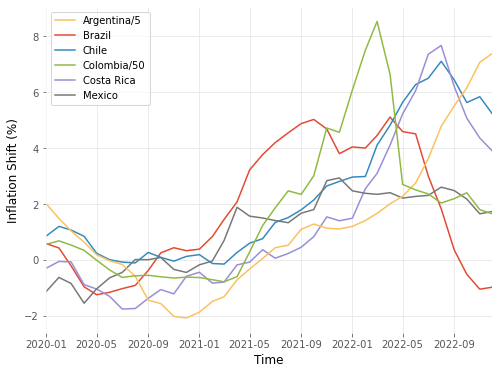

In [5]:
f_shift, a_shift = plt.subplots(figsize=(8,6), sharex=True)

# Loop through countries and plot their 'cpi' data
for c in ['bra', 'chl', 'cri', 'mex']:
    a_shift.plot(g[f'dfm_{c}']['cpi'], label=countries[c])

# Plot 'cpi' data for Argentina divided by 5
a_shift.plot(dfm_arg['cpi'] / 5, label='Argentina/5')

# Plot 'cpi' data for Colombia divided by 50
a_shift.plot(dfm_col['cpi'] / 50, label='Colombia/50')

# Set the x-axis limits
a_shift.set_xlim('2020-01-01', '2022-12-01')

# Set labels for the x and y axes
a_shift.set_xlabel('Time')
a_shift.set_ylabel('Inflation Shift (%)')

# Get legend handles and labels to customize the legend order
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,0,1,5,2,3]
plt.legend([handles[id] for id in order], [labels[id] for id in order])

f_shift.savefig('./figures/shift.png', bbox_inches='tight', dpi=100)

:::{figure-md} fig-shift
<img src='./figures/shift.png'>

Inflation shifts (%) in Latin America, according to Equation

:::

## Hidden Markov Model

Given the time series utilised to measure inflation, it is valuable to introduce two relevant ideas: stochastic process and time series. The first one refers to a temporal sequence of random variables, whereas the second to a singular realisation of a stochastic process[^rr], i.e. we have access to just one of the possible outcomes of each of these random variables, as in Equation [2](eq-stoch):

$$
    \{X_t\}_{t=-\infty}^\infty=\{...,x_{-1}, \overbrace{x_{0},x_{1},x_{2},...,x_{T}}^\text{observations, X},x_{T+1},x_{T+2},...\}
$$ (eq-stoch)

[^rr]: See {cite}`romero2020` 

Next, I use a Hidden Markov Model (HMM) to test the persistence of inflation shifts. A Hidden Markov Model is a tool for representing probability distributions over sequences of observations {cite}`ghahramani2001`, in which a sequence of observations $X$ is generated by a sequence of internal states $Z$ that follow a stochastic process. Transitions between states $Z$ are assumed to follow a Markov Model, where state $Z_t$ at time $t$ only depends on state $Z_{t-1}$ at time $t-1$.

A Hidden Markov Model has two initial components. First, there are observations, that are the inflation shift time series for each country. Table [1](t-categories) documents the selected characterization. In second place, there are hidden states that are addressed as regimes and follow the same categories as the observations: deceleration, normal shift, high acceleration and very high acceleration.


```{table} Categorization, Inflation Shifts
:name: tab-categories

| Inflation Shift     | Category              |
|---------------------|-----------------------|
| $\phi_{c,t}<0$      | Deceleration          |
| $0\leq\phi_{c,t}<2$ | Normal shift          |
| $2\leq\phi_{c,t}<4$ | High acceleration     |
| $\phi_{c,t}\geq 4$  | Very high acceleration|
```

In [6]:
for c in countries:
    # Deceleration
    g[f'dfm_{c}']['observations'] = 0

    # Normal shift
    g[f'dfm_{c}']['observations'].mask(
        (g[f'dfm_{c}']['cpi'] >= 0)
        &
        (g[f'dfm_{c}']['cpi'] < 2),
        1, inplace=True
        )

    # High acceleration
    g[f'dfm_{c}']['observations'].mask(
        (g[f'dfm_{c}']['cpi'] >= 2)
        &
        (g[f'dfm_{c}']['cpi'] < 4),
        2, inplace=True
        )

    # Very high acceleration
    g[f'dfm_{c}']['observations'].mask(
        g[f'dfm_{c}']['cpi'] >= 4,
        3, inplace=True
        )

The model requires three set parameters: first, a state transition model A that will assign a higher probability to regime persistence. This means that, for the initial model, it is more likely that after a certain regime in a specific month (let’s say deceleration at time $t$), a country shows the same regime the next month (deceleration at time $t+1$). I set the probabilities this way according to the findings of Kinlaw et al. 2022 regarding the strong regime persistence for the United States.

Next, we have an observation model B that is set to have stronger probabilities linked to same observation-regime relations. For example, if we have an observed value (let’s say high inflation shift at time $t$), it would be very likely for the model to reflect the same category (high accelerated inflation regime at time $t+1$). Both $A$ and $B$ are available in the [appendix](./06-appendix.md). Finally, we have an initial state distribution $p$ that depends on the first observation for each country. Having specified the model $λ = (A, B, p)$ I run it for each country by using the hmmlearn python package[^hmm]. In order to obtain the best score possible, this process repeats for a thousand iterations with help of a pseudo-random number generator’s (PRNG) seed.

[^hmm]: Documentation available [here](https://hmmlearn.readthedocs.io/en/latest/#).

In [7]:
A = [
    [0.85,0.05,0.05,0.05],
    [0.10,0.70,0.15,0.05],
    [0.15,0.10,0.65,0.10],
    [0.05,0.05,0.05,0.85]
    ]

B = [
    [0.70,0.10,0.10,0.10],
    [0.15,0.50,0.25,0.10],
    [0.10,0.10,0.70,0.10],
    [0.10,0.10,0.10,0.70]
    ]

In [8]:
n_iter = 10000

for c in countries:
    g[f'bestscore_{c}'] = g[f'bestmodel_{c}'] = None

    for i in range(n_iter):
        g[f'model_{c}'] = hmm.CategoricalHMM(n_components=4, tol=0, params='est', init_params='', random_state=3000)

        if g[f'dfm_{c}']['observations'][0] == 0:
            g[f'model_{c}'].startprob_ = [1,0,0,0]
        elif g[f'dfm_{c}']['observations'][0] == 1:
            g[f'model_{c}'].startprob_ = [0,1,0,0]
        elif g[f'dfm_{c}']['observations'][0] == 2:
            g[f'model_{c}'].startprob_ = [0,0,1,0]
        else:
            g[f'model_{c}'].startprob_ = [0,0,0,1]

        g[f'model_{c}'].transmat_ = A
        g[f'model_{c}'].emissionmat_ = B

        g[f'fit_{c}'] = g[f'model_{c}'].fit( [g[f'dfm_{c}']['observations']] )
        g[f'score_{c}'] = g[f'model_{c}'].score( [g[f'dfm_{c}']['observations']] )

        if g[f'bestscore_{c}'] == None or g[f'score_{c}']>g[f'bestscore_{c}']:
            g[f'bestmodel_{c}'] = g[f'model_{c}']
            g[f'bestscore_{c}'] = g[f'score_{c}']

    g[f'dfm_{c}']['predicted'] = g[f'bestmodel_{c}'].predict( [g[f'dfm_{c}']['observations']] )
    print(g[f'bestscore_{c}'])

-13.065012567083008
-23.379200978628045
-16.77365338618082
-7.490306129368112
-11.114602568293385
-14.706375444383548


It is convenient to update the `dfm`'s

In [9]:
with pd.ExcelWriter('./data/dfm.xlsx', engine='xlsxwriter') as writer:
    for c in countries:
        g[f'dfm_{c}'].to_excel(writer, sheet_name=c)

As a result, the stationary transition model shows the probabilities of staying or switching to different regimes. Figure [2](fig-HMM-chl) maps the situation for Chile. Similarly to the other countries, the regimes present strong persistence; that is, if Chile happens to be in a regime (let’s say, with normal inflation at time $t$), it is very likely that it stays in such regime the next period (having a normal inflation state at time $t+1$). Almost all analysed countries present strong persistence, as the elements in the diagonal of the transition matrix are substantially higher than the non-diagonal elements.

:::{figure-md} fig-HMM-chl
<img src='./figures/hmm_chl.png'>

Transition matrix, Chile
:::

:::{figure-md} fig-HMM-arg
<img src='./figures/hmm_arg.png'>

Transition matrix, Argentina

:::

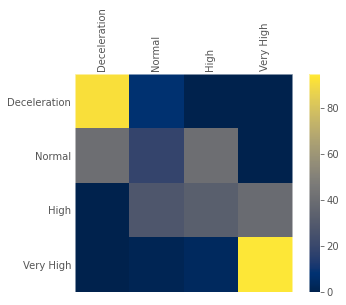

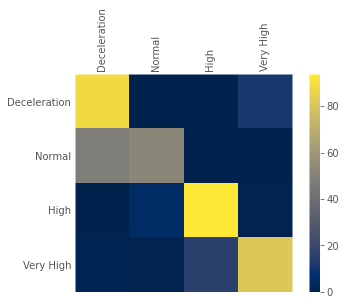

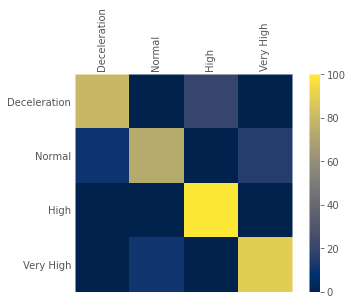

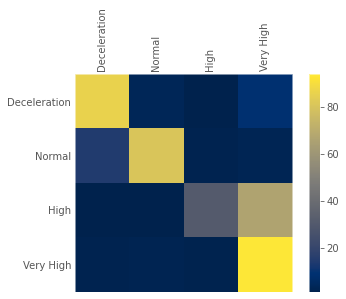

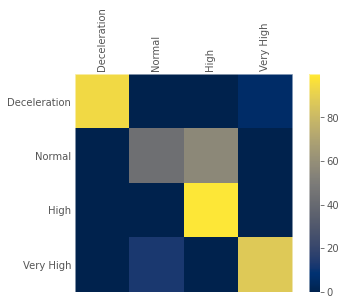

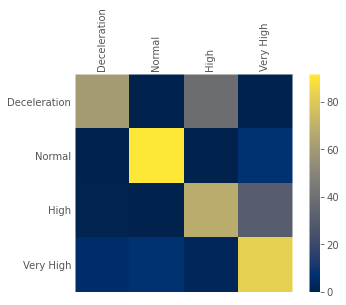

In [10]:
states = ['Deceleration','Normal','High','Very High']

for c in countries:
    g[f'transmat_{c}'] = pd.DataFrame(
        (g[f'bestmodel_{c}'].transmat_*100),
        index=states,
        columns=states
        )
    
    f_hmm, a_hmm = plt.subplots()

    raster = a_hmm.imshow(g[f'transmat_{c}'], cmap='cividis')
    f_hmm.colorbar(raster)

    a_hmm.tick_params(axis='both', which='both', length=0)

    plt.locator_params(axis='y', nbins=4)

    a_hmm.set_xticks([0,1,2,3])
    a_hmm.set_yticks([0,1,2,3])

    a_hmm.set_xticklabels(states, rotation=90)
    a_hmm.set_yticklabels(states)

    a_hmm.grid(False)
    a_hmm.xaxis.tick_top()

    f_hmm.savefig(f'./figures/hmm_{c}.png', bbox_inches='tight', dpi=100)

Nevertheless, the analysis for Argentina produces a different result. As shown in Figure [3](fig-HMM-arg), only in the limit regimes it appears to exist a high persistence (deceleration and very high acceleration). Moreover, it would be more likely to have decelerated or high accelerated inflation after being in a normal context. Furthermore, if Argentina is in a high accelerated inflation state, the expectation of staying in the same state is similar than those of shifting to a normal or very high one.